In [3]:
import random
import numpy as np
import io
import os
#import jgraph
import csv
import re
import pandas as pd
import copy as cp
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from datetime import date
import nltk
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

# Predict missing links in citation networks

The goal of this assignment is to identify missing citations in a citation network of research articles. A citation network is represented as a graph G=(V, E), where the nodes correspond to scientific articles and the existence of a directed edge between nodes u and v, indicates that paper u cites paper v.

Each node (i.e., article) is also associated with information such as the title of the paper, publication year, author names and a short abstract. A number of edges have been randomly removed from the original citation network.

Your goal is to accurately reconstruct the initial network using graph-theoretical and textual features, and possibly other information. Your solution can be based on supervised or unsupervised techniques for link prediction or on a combination of both. You should aim for the maximum F1 score.

## Loading data and preprocessing

In [4]:
# Test set
with open("data/testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]
df_test = pd.DataFrame(testing_set, columns=["source", "target"])

In [5]:
# Train set
with open("data/training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]
df_train = pd.DataFrame(training_set, columns=["source", "target", "label"])

In [6]:
df_train.shape

(615512, 3)

In [7]:
df_train.head()

,source,target,label
0,9510123,9502114,1
1,9707075,9604178,1
2,9312155,9506142,0
3,9911255,302165,0
4,9701033,209076,0


In [9]:
df_train["label"] = df_train.label.map(pd.to_numeric)

In [10]:
df_train.head()

,source,target,label
0,9510123,9502114,1
1,9707075,9604178,1
2,9312155,9506142,0
3,9911255,302165,0
4,9701033,209076,0


In [11]:
# Direct neighbors for each source node
df_neighbors = df_train.groupby("source")["target"].apply(lambda x: " ".join(x))

In [12]:
# Info for each node
with open("data/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]
df_node_info = pd.DataFrame(node_info, columns=["paper_id", "year", "title", 
                                                "authors", "journal_name", "abstract"])
df_node_info.index = df_node_info.paper_id
df_node_info.drop("paper_id", axis=1, inplace=True)

In [13]:
# Put the year column to numeric setting
df_node_info["year"] = df_node_info.year.map(pd.to_numeric)

In [14]:
def process_text(t):
    # Remove stopwords, lower and tokenize
    result = t.lower().split(" ")
    result = [token for token in result if token not in stpwds]
    return result

In [15]:
df_node_info["prcssd_title"] = df_node_info["title"].map(lambda t: process_text(t))
df_node_info["prcssd_authors"] = df_node_info["authors"].map(lambda l: [author for author in l.split(",") if author not in (" ", "")])
df_node_info["prcssd_abstract"] = df_node_info["abstract"].map(lambda t: process_text(t))

Let's process the author names to be consistent:

In [16]:
def format_author_name(author_name):
    """Format the author name (string) as N Benabderrazik. If there are 
    multiple first names it would be: A B FamilyName where A and B are 
    the first letters of the respective first names.
    """
    # Keep only strings before an opening parenthesis (e.g. discard (Montpellier))
    author_name = re.sub(r"\(.*$", "", author_name)
    
    # Keep only word characters
    author_name = re.findall(r"[\w']+", author_name)
    
    # Turn the first names to initials and keep the family name as is
    author_name = [author_name[i][0] if i < len(author_name)-1 else author_name[i] 
              for i in range(len(author_name))]
    
    return " ".join(author_name)

In [17]:
def format_author_names(author_names):
    """Format a list of author names.
    """
    return [format_author_name(author_name) for author_name in author_names]

In [18]:
df_node_info["prcssd_authors"] = df_node_info["prcssd_authors"]\
                                  .apply(lambda x: format_author_names(x))

In [19]:
df_node_info.head()

,year,title,authors,journal_name,abstract,prcssd_title,prcssd_authors,prcssd_abstract
paper_id,,,,,,,,
1001,2000,compactification geometry and duality,Paul S. Aspinwall,,these are notes based on lectures given at tas...,"[compactification, geometry, duality]",[P S Aspinwall],"[notes, based, lectures, given, tasi99, review..."
1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...,"[domain, walls, massive, gauged, supergravity,...","[M Cvetic, H Lu, C N Pope]","[point, massive, gauged, supergravity, potenti..."
1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",,recently ivanov and volovich hep-th 9912242 cl...,"[comment, metric, fluctuations, brane, worlds]","[Y S Myung, G Kang]","[recently, ivanov, volovich, hep-th, 9912242, ..."
1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...,"[moving, mirrors, thermodynamic, paradoxes]",[A D Helfer],"[quantum, fields, responding, moving, mirrors,..."
1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",,proceedings of lie iii clausthal july 1999 var...,"[bundles, chiral, blocks, boundary, conditions...","[J Fuchs, C Schweigert]","[proceedings, lie, iii, clausthal, july, 1999,..."


### Neighbors

In this section we get the direct neighbors for each node.

In [20]:
# Direct neighbors for each source node
df_neighbors = df_train.groupby("source")["target"].apply(lambda x: " ".join(x))

In [21]:
df_node_info = df_node_info.join(df_neighbors)
df_node_info.rename(columns={"target": "neighbors"}, inplace=True)

In [22]:
df_node_info.head()

,year,title,authors,journal_name,abstract,prcssd_title,prcssd_authors,prcssd_abstract,neighbors
paper_id,,,,,,,,,
1001,2000,compactification geometry and duality,Paul S. Aspinwall,,these are notes based on lectures given at tas...,"[compactification, geometry, duality]",[P S Aspinwall],"[notes, based, lectures, given, tasi99, review...",9603161 9702094 9703082 9507158 9404151 950103...
1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...,"[domain, walls, massive, gauged, supergravity,...","[M Cvetic, H Lu, C N Pope]","[point, massive, gauged, supergravity, potenti...",9912012 9812035 9902155 9606076 9809015 4158 9...
1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",,recently ivanov and volovich hep-th 9912242 cl...,"[comment, metric, fluctuations, brane, worlds]","[Y S Myung, G Kang]","[recently, ivanov, volovich, hep-th, 9912242, ...",205120 9409090 211182 9912242 208125 9709049 9...
1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...,"[moving, mirrors, thermodynamic, paradoxes]",[A D Helfer],"[quantum, fields, responding, moving, mirrors,...",7129 9305170 9608190 209232 9910133 104118 990...
1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",,proceedings of lie iii clausthal july 1999 var...,"[bundles, chiral, blocks, boundary, conditions...","[J Fuchs, C Schweigert]","[proceedings, lie, iii, clausthal, july, 1999,...",9908025 9909114 4153 9805026 9307074 9607157 9...


In [23]:
df_node_info["neighbors"] = df_node_info["neighbors"].apply(lambda x: x.split())

In [24]:
df_node_info.head()

,year,title,authors,journal_name,abstract,prcssd_title,prcssd_authors,prcssd_abstract,neighbors
paper_id,,,,,,,,,
1001,2000,compactification geometry and duality,Paul S. Aspinwall,,these are notes based on lectures given at tas...,"[compactification, geometry, duality]",[P S Aspinwall],"[notes, based, lectures, given, tasi99, review...","[9603161, 9702094, 9703082, 9507158, 9404151, ..."
1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...,"[domain, walls, massive, gauged, supergravity,...","[M Cvetic, H Lu, C N Pope]","[point, massive, gauged, supergravity, potenti...","[9912012, 9812035, 9902155, 9606076, 9809015, ..."
1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",,recently ivanov and volovich hep-th 9912242 cl...,"[comment, metric, fluctuations, brane, worlds]","[Y S Myung, G Kang]","[recently, ivanov, volovich, hep-th, 9912242, ...","[205120, 9409090, 211182, 9912242, 208125, 970..."
1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...,"[moving, mirrors, thermodynamic, paradoxes]",[A D Helfer],"[quantum, fields, responding, moving, mirrors,...","[7129, 9305170, 9608190, 209232, 9910133, 1041..."
1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",,proceedings of lie iii clausthal july 1999 var...,"[bundles, chiral, blocks, boundary, conditions...","[J Fuchs, C Schweigert]","[proceedings, lie, iii, clausthal, july, 1999,...","[9908025, 9909114, 4153, 9805026, 9307074, 960..."


## Bag of Words Abstract

Abstract embedding thanks to Bag of Vector

In [22]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict(zip(self.word2vec.keys(), range(len(self.word2vec.keys()))))
        self.id2word = {v: k for k, v in self.word2id.items()}
        #self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        w1_embd = self.word2vec[w1]
        w2_embd = self.word2vec[w2]
        
        cosine_sim = w1_embd.dot(w2_embd)/(np.linalg.norm(w1_embd)*np.linalg.norm(w2_embd))
        return cosine_sim


class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                # number of words for which we have an embedding
                n_words = sum([1 for word in sent if word in self.w2v.word2id])
                
                # compute sentence embedding only if we have the embedding of at least one word
                if n_words > 0:
                    # vector with the sum of all word embeddings element-wise
                    sum_embd = np.sum(np.array([w2v.word2vec[word] for word in sent if word in self.w2v.word2id]), axis=0)
                    mean_embd = sum_embd/n_words
                    sentemb.append(np.array(mean_embd))
                # if no embedding found, append a random embedding
                else:
                    sentemb.append(np.random.rand(300))
            else:
                # idf-weighted mean of word vectors
                assert False, 'TODO: fill in the blank'
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)[0]
        
        scores = []
        for key in keys:
            score = self.score(query, key)
            scores.append(score)
        scores = np.array(scores)
        argsorted_scores = np.argsort(scores)[::-1]
        return [" ".join(sentences[arg]) for arg in argsorted_scores[1:K+1]]

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        cosine_sim = s1.dot(s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
        return cosine_sim

In [23]:
w2v = Word2vec(os.path.join("data/crawl-300d-200k.vec"), nmax=200000)
s2v = BoV(w2v)

Loaded 200000 pretrained word vectors


In [24]:
df_node_info["abstract_embd"] = [embd for embd in s2v.encode(df_node_info.prcssd_abstract)]

In [25]:
abstract = df_node_info.prcssd_abstract[20]
print(abstract)
s2v.most_similar(abstract, df_node_info.prcssd_abstract, K=2)

['study', 'two', 'loop', 'quantum', 'equivalence', 'sigma', 'models', 'related', "buscher's", 't-duality', 'transformation', 'computation', 'two', 'loop', 'perturbative', 'free', 'energy', 'density', 'performed', 'case', 'certain', 'deformation', 'su', '2', 'principal', 'sigma', 'model', 't-dual', 'using', 'dimensional', 'regularization', 'geometric', 'sigma', 'model', 'perturbation', 'theory', 'obtain', 'agreement', 'free', 'energy', 'density', 'expressions', 'two', 'models']


['matrix proposed two dimensional 3 sigma model dynamical theta term axion model exploiting abelian t-duality transformation connecting axion model integrable su 2 times u 1 symmetric principal sigma model strong evidence presented correctness proposed matrix comparing perturbatively calculated free energies ones based thermodynamical bethe ansatz t-duality transformation also leads new lax-pair models quantum non-integrability 3 sigma model sl constant theta term contradistinction axion model illustrated calculating 2 to3 particle production amplitude lowest order theta',
 'modification abelian duality transformations proposed guaranteeing necessarily conformally invariant sigma model quantum equivalent least two loops perturbation theory dual requires somewhat non standard perturbative treatment sl dual sigma model explicit formulae modified duality transformation presented special class block diagonal purely metric sigma models']

## More insights on the data

In [26]:
# Number of unique journals
n_unique = list(df_node_info.journal_name.unique())
print("{} unique journals".format(len(n_unique)))

285 unique journals


In [27]:
# One sample abstract
df_node_info.abstract[0]

'these are notes based on lectures given at tasi99 we review the geometry of the moduli space of n 2 theories in four dimensions from the point of view of superstring compactification the cases of a type iia or type iib string compactified on a calabi-yau threefold and the heterotic string compactified on k3xt2 are each considered in detail we pay specific attention to the differences between n 2 theories and n 2 theories the moduli spaces of vector multiplets and the moduli spaces of hypermultiplets are reviewed in the case of hypermultiplets this review is limited by the poor state of our current understanding some peculiarities such as mixed instantons and the non-existence of a universal hypermultiplet are discussed'

--> Commentaire Nabil : pas compris ce que ça fait là

## Random baseline

In [ ]:
###################
# random baseline #
###################

random_predictions = np.random.choice([0, 1], size=len(testing_set))
random_predictions = zip(range(len(testing_set)),random_predictions)

with open("predictions/random_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    for row in random_predictions:
        csv_out.writerow(row)
        
# note: Kaggle requires that you add "ID" and "category" column headers

## Beating random baseline

In [ ]:
## the following shows how to construct a graph with igraph
## even though in this baseline we don't use it
## look at http://igraph.org/python/doc/igraph.Graph-class.html for feature ideas

#edges = [(element[0],element[1]) for element in training_set if element[2]=="1"]

## some nodes may not be connected to any other node
## hence the need to create the nodes of the graph from node_info.csv,
## not just from the edge list

#nodes = IDs

## create empty directed graph
#g = igraph.Graph(directed=True)
 
## add vertices
#g.add_vertices(nodes)
 
## add edges
#g.add_edges(edges)

# for each training example we need to compute features
# in this baseline we will train the model on only 5% of the training set

### Training

In [ ]:
###############################
# beating the random baseline #
###############################

# the following script gets an F1 score of approximately 0.66

# data loading and preprocessing 

# the columns of the data frame below are: 
# (1) paper unique ID (integer)
# (2) publication year (integer)
# (3) paper title (string)
# (4) authors (strings separated by ,)
# (5) name of journal (optional) (string)
# (6) abstract (string) - lowercased, free of punctuation except intra-word dashes


# compute TFIDF vector of each paper
corpus = [element[5] for element in node_info]
vectorizer = TfidfVectorizer(stop_words="english")
# each row is a node in the order of node_info
features_TFIDF = vectorizer.fit_transform(corpus)

# randomly select 5% of training set
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
training_set_reduced = [training_set[i] for i in to_keep]

In [ ]:
# convert labels into integers then into column array
labels = [int(element[2]) for element in training_set_reduced]
labels = list(labels)
labels_array = np.array(labels)

# initialize basic SVM
classifier = svm.LinearSVC()

# train
classifier.fit(training_features, labels_array)

### Testing

In [ ]:
# test
# we need to compute the features for the testing set

# number of overlapping words in title
overlap_title_test = []
# temporal distance between the papers
temp_diff_test = []
# number of common authors
comm_auth_test = []
   
counter = 0
for i in range(len(testing_set)):
    source = testing_set[i][0]
    target = testing_set[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source = testing_set[i][0]
    target = testing_set[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
    source_title = source_info[2].lower().split(" ")
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    overlap_title_test.append(len(set(source_title).intersection(set(target_title))))
    temp_diff_test.append(int(source_info[1]) - int(target_info[1]))
    comm_auth_test.append(len(set(source_auth).intersection(set(target_auth))))

# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
testing_features = np.array([overlap_title_test,temp_diff_test,comm_auth_test]).T

# scale
testing_features = preprocessing.scale(testing_features)

In [ ]:
# issue predictions
predictions_SVM = list(classifier.predict(testing_features))

# write predictions to .csv file suitable for Kaggle (just make sure to add the column names)
predictions_SVM = zip(range(len(testing_set)), predictions_SVM)

with open("predictions/improved_predictions.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(("id", "category"))
    for row in predictions_SVM:
        csv_out.writerow(row)

## Personal work

### Feature engineering

**TO DO**

- Implement and test Adamic/Adar similarity **ok**
- Implement and test Preferiential attachment **ok**
- Implement and test Katz measure **ok, mais j'ai computé un score par noeud. Il me semble qu'il existe aussi un score par couple de neoud**
- ... and the other features mentionned in slide 41 of lecture 5
- Dans la fonction  `feature_engineer`, spécifier le nom des variables que l'on veut générer

#### Join with node info

In [32]:
df_train.iloc[0, 0]

'9510123'

In [25]:
df_node_info_source = cp.deepcopy(df_node_info)
df_node_info_source.columns = [col+"_source" for col in df_node_info.columns]
df_train_inc = df_train.join(df_node_info_source, on="source")

df_node_info_target = cp.deepcopy(df_node_info)
df_node_info_target.columns = [col+"_target" for col in df_node_info.columns]
df_train_comp = df_train_inc.join(df_node_info_target, on="target")

In [26]:
df_train_comp.head()

,source,target,label,year_source,title_source,authors_source,journal_name_source,abstract_source,prcssd_title_source,prcssd_authors_source,...,neighbors_source,year_target,title_target,authors_target,journal_name_target,abstract_target,prcssd_title_target,prcssd_authors_target,prcssd_abstract_target,neighbors_target
0,9510123,9502114,1,1995,an infinite number of potentials surrounding 2...,,Phys.Lett.,we found an infinite number of potentials surr...,"[infinite, number, potentials, surrounding, 2d...",[],...,"[9502114, 9408144, 9302075, 9411220, 108214, 9...",1995,stability analysis of the dilatonic black hole...,"Won T. Kim, Julian Lee, , Young Jai Park",Phys.Lett.,we explicitly show that the net number of degr...,"[stability, analysis, dilatonic, black, hole, ...","[W T Kim, J Lee, Y J Park]","[explicitly, show, net, number, degrees, freed...","[9201074, 9707129, 105264, 9210120, 9809016, 9..."
1,9707075,9604178,1,1997,d 6 n 1 string vacua and duality,"L.E.Ibanez, A.M.Uranga",,winter school on duality mt sorak korea februa...,"[6, n, 1, string, vacua, duality]","[L E Ibanez, A M Uranga]",...,"[9604178, 9603150, 9602097, 9203071, 103180, 9...",1996,strings on orientifolds,"Atish Dabholkar, Jaemo Park",Nucl.Phys.,we construct several examples of compactificat...,"[strings, orientifolds]","[A Dabholkar, J Park]","[construct, several, examples, compactificatio...","[9510209, 111018, 9509080, 9505054, 110084, 96..."
2,9312155,9506142,0,1993,conformal field theory and hyperbolic geometry,"P. Kleban, I. Vassileva",Phys.Rev.Lett.,we examine the correspondence between the conf...,"[conformal, field, theory, hyperbolic, geometry]","[P Kleban, I Vassileva]",...,"[9506142, 9705203, 12201, 209121, 9806107, 203...",1995,wightman functions behaviour on the event hori...,"V. Moretti (Dept. Phys. Univ. Trento Italy, INFN)",Class.Quant.Grav.,reissner-nordstr om black hole results followi...,"[wightman, functions, behaviour, event, horizo...","[V Moretti, INFN]","[reissner-nordstr, om, black, hole, results, f...","[9402155, 9811223, 9911148, 9608126, 9203019, ..."
3,9911255,302165,0,1999,comparing instanton contributions with exact r...,"Philip C. Argyres, Sophie Pell,",JHEP,supersymmetric scale invariant theories we dis...,"[comparing, instanton, contributions, exact, r...","[P C Argyres, S Pell]",...,"[302165, 9505100, 9607076, 9509175, 9609104, 9...",2003,five-dimensional gauge theories and quantum me...,Timothy J. Hollowood,,we show how the dijkgraaf-vafa matrix model pr...,"[five-dimensional, gauge, theories, quantum, m...",[T J Hollowood],"[show, dijkgraaf-vafa, matrix, model, proposal...","[9906011, 9911020, 9609239, 209223, 210239, 20..."
4,9701033,209076,0,1997,quantum gravitational measure for three-geomet...,,Phys.Lett.,that with some modifications was published in ...,"[quantum, gravitational, measure, three-geomet...",[],...,"[209076, 9407082, 9803168, 207213, 9610055, 10...",2002,israel conditions for the gauss-bonnet theory ...,"Elias Gravanis, Steven Willison",,on the brane universe additional bulk fields a...,"[israel, conditions, gauss-bonnet, theory, fri...","[E Gravanis, S Willison]","[brane, universe, additional, bulk, fields, as...","[9704055, 109133, 9910149, 205299, 9611162, 99..."


#### Common words in titles

In [24]:
def compare_texts(t1, t2):
    n_overlapping_words = sum([1 for token in t1 if token in t2])
    return n_overlapping_words

In [25]:
df_train_comp["overlap_title"] = df_train_comp.apply(lambda row: compare_texts(row["prcssd_title_source"], row["prcssd_title_target"]), axis=1)

#### Common word in abstracts

In [26]:
df_train_comp["overlap_abstract"] = df_train_comp.apply(
    lambda row: compare_texts(row["prcssd_abstract_source"], row["prcssd_abstract_target"]), axis=1)

#### Cosine similarity abstract

In [34]:
df_train_comp["cosine_sim_abstract"] = df_train_comp.apply(
    lambda row: s2v.score(row["abstract_embd_source"], row["abstract_embd_target"]), axis=1)

#### Number of common authors

In [27]:
def count_common_authors(l_authors1, l_authors2):
    n_common_authors = sum([1 for author in l_authors1 if author in l_authors2])
    return n_common_authors

# Commenataire Nabil : plus de sens de mettre le ratio de common authors ? haha petit détail, pense pas que ça va
# changer grand chose



In [28]:
df_train_comp["common_authors"] = df_train_comp.apply(
    lambda row: count_common_authors(row["prcssd_authors_source"], row["prcssd_authors_target"]), axis=1)

#### Temporal difference

In [29]:
df_train_comp["temp_diff"] = df_train_comp.apply(
    lambda row: row["year_source"]-row["year_target"], axis=1)

Among lines that have ```temp_diff < 0```, how many have ```label = 0``` ?

In [38]:
n_temp_lt_0 = df_train_comp[df_train_comp.temp_diff < 0].shape[0]
n_both = df_train_comp[(df_train_comp.temp_diff < 0) & (df_train_comp.label == 0)].shape[0]
print("Proportion: {:.2%}".format(n_both/n_temp_lt_0))

Proportion: 98.36%


We will always predict 0 for lines that have ```temp_diff < 0```.

#### Do the source and target belong to the same journal?

In [30]:
df_train_comp["is_same_journal"] = ((df_train_comp.journal_name_source == df_train_comp.journal_name_target) 
                                    & (df_train_comp.journal_name_source != "")).astype("int")

Let's check the relevance of the `common_authors` variable:

In [40]:
df_train_comp.common_authors.value_counts()


0    569972
1     30602
2     10957
3      3214
4       672
5        87
6         6
8         2
Name: common_authors, dtype: int64

#### Jaccard coefficient 

In [31]:
def jaccard_coefficient(neighbors_target, neighbors_source):
    """Compute the jaddart coefficient between a source and a target node. 
    The neighbors are represented by a list of strings.
    """
    common_neighbors = len(set(neighbors_source).intersection(set(neighbors_target)))
    total_neighbors = len(neighbors_source+neighbors_target)
    return common_neighbors/total_neighbors

In [32]:
df_train_comp["jaccard_coefficient"] = df_train_comp.apply(
    lambda row: jaccard_coefficient(row["neighbors_source"], row["neighbors_target"]), 
    axis=1)

#### Adamic/Adar similarity

**ATTENTION** Notre graph G est normalement un graph direct. Or, on ne peut pas calculer adamic adar similarity si le graph est direct. On passe alors par un grap indirect

In [33]:
# Initiate the Graph
G = nx.Graph()

# Add the nodes from the source and target columns
G.add_nodes_from(df_train_comp['source'])
G.add_nodes_from(df_train_comp['target'])

# Add the edges
edges = [(df_train_comp['source'][i], df_train_comp['target'][i]) for i in range(len(df_train_comp))
        if df_train_comp['label'][i] == 1]
G.add_edges_from(edges)

In [34]:
to_compute = [(df_train_comp['source'][i], df_train_comp['target'][i]) for i in range(len(df_train_comp))]
preds = nx.adamic_adar_index(G, to_compute)

In [35]:
preds_dico = {(source, target): sim for (source, target, sim) in preds}

In [36]:
df_train_comp["AAsim"] = df_train_comp.apply(
    lambda row: preds_dico[(row["source"], row["target"])], 
    axis=1)

#### Preferential attachment

In [37]:
to_compute = [(df_train_comp['source'][i], df_train_comp['target'][i]) for i in range(len(df_train_comp))]
preds_pa = nx.preferential_attachment(G, to_compute)

In [38]:
preds_pa_dico = {(source, target): sim for (source, target, sim) in preds_pa}

In [39]:
df_train_comp["pref_attachment"] = df_train_comp.apply(
    lambda row: preds_pa_dico[(row["source"], row["target"])], 
    axis=1)

#### Katz centrality

In [ ]:
#adj_matrix = np.array(nx.adjacency_matrix(G).todense())
#phi = max(np.linalg.eigvals(adj_matrix))

In [40]:
#centrality_dico = nx.katz_centrality(G, 1/phi)
%time centrality_dico = nx.katz_centrality(G)

KeyboardInterrupt: 

In [ ]:
df_train_comp["katz_centrality_source"] = df_train_comp.apply(
    lambda row: centrality_dico[row["source"]], 
    axis=1)

In [ ]:
df_train_comp["katz_centrality_target"] = df_train_comp.apply(
    lambda row: centrality_dico[row["target"]], 
    axis=1)

#### Has path

In [41]:
# Initiate a directed Graph
G_dir = nx.DiGraph()

# Add the nodes from the source and target columns
G_dir.add_nodes_from(df_train_comp['source'])
G_dir.add_nodes_from(df_train_comp['target'])

# Add the edges
edges = [(df_train_comp['source'][i], df_train_comp['target'][i]) for i in range(len(df_train_comp))
        if df_train_comp['label'][i] == 1]
G_dir.add_edges_from(edges)

In [44]:
%%time 
df_train_comp["has_path"] = df_train_comp.apply(
    lambda row: int(nx.has_path(G_dir,row["source"],row["target"])),
    axis=1)

KeyboardInterrupt: 

#### Lenght of the shortest path between 2 nodes

In [ ]:
df_train_comp["shortest_path"] = df_train_comp.apply(
    lambda row: nx.shortest_path_length(G_dir,source = row["source"],target = row["target"])
    if row["has_path"] == 1
    else -1,
    axis=1)

#### Common neighbors

In [47]:
df_train_comp["common_ngbrs"] = df_train_comp.apply(
    lambda row: len(list(nx.common_neighbors(G, row["source"], row["target"]))),
    axis=1)

#### Max flow

In [48]:
df_train_comp["max_flow_value"] = df_train_comp.apply(
    lambda row: nx.maximum_flow_value(G, row["source"], row["target"]),
    axis=1)

NetworkXUnbounded: ('Infinite capacity path, flow unbounded above.', 'occurred at index 0')

#### All processing

In the `feature_engineer` function we add new features to the initial dataframe:

In [32]:
# Create the graph as an undirected graph
#Initiate the Graph
G = nx.Graph()

# Add the nodes from the source and target columns
G.add_nodes_from(df_train_comp['source'])
G.add_nodes_from(df_train_comp['target'])

# Add the edges
edges = [(df_train_comp['source'][i], df_train_comp['target'][i]) for i in range(len(df_train_comp))
        if df_train_comp['label'][i] == 1]
G.add_edges_from(edges)

In [36]:
# Create the graph as an directed graph
#Initiate a direct Graph
G_dir = nx.DiGraph()

# Add the nodes from the source and target columns
G_dir.add_nodes_from(df_train_comp['source'])
G_dir.add_nodes_from(df_train_comp['target'])

# Add the edges
edges = [(df_train_comp['source'][i], df_train_comp['target'][i]) for i in range(len(df_train_comp))
        if df_train_comp['label'][i] == 1]
G_dir.add_edges_from(edges)

In [54]:
def compare_texts(t1, t2):
    n_overlapping_words = sum([1 for token in t1 if token in t2])
    return n_overlapping_words

def count_common_authors(l_authors1, l_authors2):
    n_common_authors = sum([1 for author in l_authors1 if author in l_authors2])
    return n_common_authors

def jaccard_coefficient(neighbors_target, neighbors_source):
    """Compute the jaddart coefficient between a source and a target node. 
    The neighbors are represented by a list of strings.
    """
    common_neighbors = len(set(neighbors_source).intersection(set(neighbors_target)))
    total_neighbors = len(neighbors_source+neighbors_target)
    return common_neighbors/total_neighbors

def AAsim(df_comp, G):
    to_compute = [(df_comp['source'][i], df_comp['target'][i]) for i in range(len(df_comp))] 
    preds = nx.adamic_adar_index(G, to_compute)
    
    preds_dico = {(source, target): sim for (source, target, sim) in preds}
    
    return preds_dico

def prefatt(df_comp, G):
    to_compute = [(df_comp['source'][i], df_comp['target'][i]) for i in range(len(df_comp))]
    preds_pa = nx.preferential_attachment(G, to_compute)
    
    preds_pa_dico = {(source, target): sim for (source, target, sim) in preds_pa}
    
    return preds_pa_dico

def Katz_centrality(G):
    centrality_dico = nx.katz_centrality(G)
    
    return centrality_dico

# Has path ok
#Shortest path ok
#Common neighbors ok
# Max flow value ok

# All previous feature engineering in one function
def feature_engineer(df, df_node_info, features=None):
    """Specify the list of features to compute in features.
    """
    # Join
    df_node_info_source = cp.deepcopy(df_node_info)
    df_node_info_source.columns = [col+"_source" for col in df_node_info.columns]
    df_inc = df.join(df_node_info_source, on="source")
    
    df_node_info_target = cp.deepcopy(df_node_info)
    df_node_info_target.columns = [col+"_target" for col in df_node_info.columns]
    df_comp = df_inc.join(df_node_info_target, on="target")
    print("Joining: ok!")
    
    # Common words in title
    if "title" in features or features is None:
        df_comp["overlap_title"] = df_comp.apply(
            lambda row: compare_texts(row["prcssd_title_source"], row["prcssd_title_target"]), 
            axis=1)
        print("Common words in title: ok!")
    
    # Number of common authors
    if "title" in features or features is None:
        df_comp["common_authors"] = df_comp.apply(
            lambda row: count_common_authors(row["prcssd_authors_source"], row["prcssd_authors_target"]), 
            axis=1)
        print("Common authors: ok!")
    
    # Temporal difference
    if "temp" in features or features is None:
        df_comp["temp_diff"] = df_comp.apply(
            lambda row: row["year_source"]-row["year_target"], axis=1)
        print("Temporal difference: ok!")

    # Common words in abstract
    if "abstract" in features or features is None:
        df_comp["overlap_abstract"] = df_comp.apply(
            lambda row: compare_texts(row["prcssd_abstract_source"], row["prcssd_abstract_target"]), 
            axis=1)
        print("Common words in abstract: ok!")
    
    if "cosine_abstract" in features or features is None:
        df_comp["cosine_sim_abstract"] = df_comp.\
                                 apply(lambda row: s2v.score(row["abstract_embd_source"], 
                                                     row["abstract_embd_target"]), axis=1)
        print("Cosine similarity abstract: ok!")
    
    # Source and target belong to the same journal ?
    if "journal" in features or features is None:
        df_comp["is_same_journal"] = ((df_comp.journal_name_source == df_comp.journal_name_target) & (df_comp.journal_name_source != "")).astype("int")
        print("Same journal: ok!")
    
    if "jaccard" in features or features is None:
        df_comp["jaccard_coefficient"] = df_comp.apply(
        lambda row: jaccard_coefficient(row["neighbors_source"], row["neighbors_target"]), 
        axis=1)
        print("Jaccard Coefficient: ok!")
    
    # Adamic Adar similarity
    if "addar" in features or features is None:
        preds_dico = AAsim(df_comp, G)
        df_comp["AAsim"] = df_comp.apply(
        lambda row: preds_dico[(row["source"], row["target"])], 
        axis=1)
        print("Adamic Adar similarity: ok!")
    
    # Preferential attachment
    if "pr" in features or features is None:
        preds_pa_dico = prefatt(df_comp, G)
        df_comp["pref_attachment"] = df_comp.apply(
        lambda row: preds_pa_dico[(row["source"], row["target"])], 
        axis=1)
        print("Preferential attachment: ok!")

    # Katz centrality (très long)
    if "katz" in features or features is None:
        centrality_dico = Katz_centrality(G)
        df_comp["katz_centrality_source"] = df_comp.apply(
        lambda row: centrality_dico[row["source"]], 
        axis=1)
        df_comp["katz_centrality_target"] = df_comp.apply(
        lambda row: centrality_dico[row["target"]], 
        axis=1)
        print("Katz centrality: ok!")
    
    # Has path (long)
    if "has_path" in features or features is None:
        df_comp["has_path"] = df_comp.apply(
        lambda row: int(nx.has_path(G_dir,row["source"],row["target"])),
        axis=1)
        print("Has path: ok")
    
    # Shortest path (long)
    if "shortest_path" in features or features is None:
        df_train_comp["shortest_path"] = df_train_comp.apply(
        lambda row: nx.shortest_path_length(G_dir,source = row["source"],target = row["target"])
        if row["has_path"] == 1
        else -1,
        axis=1)
        print("Shortest path: ok!")

    # Common neighbors
    if "common_neighbors" in features or features is None:
        df_train_comp["common_ngbrs"] = df_train_comp.apply(
            lambda row: len(list(nx.common_neighbors(G, row["source"], row["target"]))),
            axis=1)
        print("Common neighbors: ok!")
    
    # Max flow values
    if "max_flow" in features or features is None:
        df_comp["max_flow_value"] = df_comp.apply(
        lambda row: nx.maximum_flow_value(G, row["source"], row["target"]),
        axis=1)
        print("Max flow values: ok!")
    
    
    return df_comp

In [66]:
df_train_comp = feature_engineer(df_train, df_node_info)

Joining: ok!
Common words in title: ok!
Common authors: ok!
Temporal difference: ok!
Common words in abstract: ok!
Cosine similarity abstract: ok!
Same journal: ok!
Jaccard Coefficient: ok!
Adamic Adar similarity: ok!
Preferential attachment: ok!


TypeError: ("object of type 'generator' has no len()", 'occurred at index 0')

In [49]:
df_train_comp.head()

,source,target,label,year_source,title_source,authors_source,journal_name_source,abstract_source,prcssd_title_source,prcssd_authors_source,...,neighbors_target,overlap_title,overlap_abstract,common_authors,temp_diff,is_same_journal,jaccard_coefficient,AAsim,pref_attachment,common_ngbrs
0,9510123,9502114,1,1995,an infinite number of potentials surrounding 2...,,Phys.Lett.,we found an infinite number of potentials surr...,"[infinite, number, potentials, surrounding, 2d...",[],...,"[9201074, 9707129, 105264, 9210120, 9809016, 9...",2,6,0,0,1,0.062500,0.513898,72,1
1,9707075,9604178,1,1997,d 6 n 1 string vacua and duality,"L.E.Ibanez, A.M.Uranga",,winter school on duality mt sorak korea februa...,"[6, n, 1, string, vacua, duality]","[L E Ibanez, A M Uranga]",...,"[9510209, 111018, 9509080, 9505054, 110084, 96...",0,6,0,1,0,0.069565,4.320366,11613,20
2,9312155,9506142,0,1993,conformal field theory and hyperbolic geometry,"P. Kleban, I. Vassileva",Phys.Rev.Lett.,we examine the correspondence between the conf...,"[conformal, field, theory, hyperbolic, geometry]","[P Kleban, I Vassileva]",...,"[9402155, 9811223, 9911148, 9608126, 9203019, ...",0,4,0,-2,0,0.000000,0.000000,5,0
3,9911255,302165,0,1999,comparing instanton contributions with exact r...,"Philip C. Argyres, Sophie Pell,",JHEP,supersymmetric scale invariant theories we dis...,"[comparing, instanton, contributions, exact, r...","[P C Argyres, S Pell]",...,"[9906011, 9911020, 9609239, 209223, 210239, 20...",0,6,0,-4,0,0.000000,0.000000,280,0
4,9701033,209076,0,1997,quantum gravitational measure for three-geomet...,,Phys.Lett.,that with some modifications was published in ...,"[quantum, gravitational, measure, three-geomet...",[],...,"[9704055, 109133, 9910149, 205299, 9611162, 99...",0,5,0,-5,0,0.000000,0.000000,168,0


### Model

In [51]:
features = ["year_source", "overlap_title", "common_authors", "temp_diff", "overlap_abstract",
            "is_same_journal", "jaccard_coefficient", "AAsim", "pref_attachment", 
            "common_ngbrs"]
# Train only on data with temp_diff > 0
X = df_train_comp[features]
y = df_train_comp.label

In [52]:
# Initialize Random Forest classifier
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
# Set a k-fold cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True)
    
# Get average cross-validation on 5 folds
print("Mean of cross-validation F1: {:.2f}"\
    .format(cross_val_score(clf, X, y, cv=cv, scoring='f1')\
    .mean()))

Mean of cross-validation F1: 0.97


Let's get the feature importances for the Random Forest classifier:

Feature ranking:
1. feature common_ngbrs (0.344697)
2. feature jaccard_coefficient (0.264291)
3. feature AAsim (0.256332)
4. feature pref_attachment (0.055488)
5. feature temp_diff (0.029636)
6. feature overlap_abstract (0.015910)
7. feature common_authors (0.014633)
8. feature year_source (0.011561)
9. feature overlap_title (0.006396)
10. feature is_same_journal (0.001057)


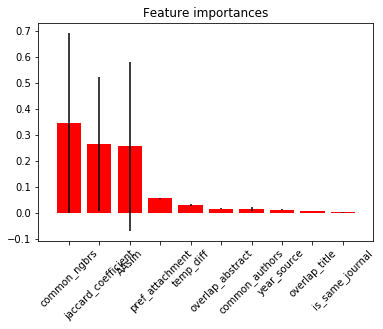

In [53]:
clf.fit(X, y)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the clf
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [features[index] for index in indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

#### Gradient Boosting 

In [69]:
clf = GradientBoostingClassifier(n_estimators=10)
# Set a k-fold cross validation
cv = StratifiedKFold(n_splits=3, shuffle=True)
    
# Get average cross-validation on 5 folds
print("Mean of cross-validation F1: {:.2f}"\
    .format(cross_val_score(clf, X, y, cv=cv, scoring='f1')\
    .mean()))

Mean of cross-validation F1: 0.97


#### Log reg

In [32]:
clf = LogisticRegression(C=0.001, verbose=1)
# Set a k-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True)
    
# Get average cross-validation on 5 folds
print("Mean of cross-validation F1: {:.2f}"\
    .format(cross_val_score(clf, X, y, cv=cv, scoring='f1')\
    .mean()))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Mean of cross-validation F1: 0.80


#### SVM 

In [ ]:
# clf = SVC()
# # Set a k-fold cross validation
# cv = StratifiedKFold(n_splits=5, shuffle=True)
    
# # Get average cross-validation on 5 folds
# print("Mean of cross-validation F1: {:.2f}"\
#     .format(cross_val_score(clf, X, y, cv=cv, scoring='f1')\
#     .mean()))

### Predictions

In [70]:
df_test_comp = feature_engineer(df_test, df_node_info)

Joining: ok!
Common words in title: ok!
Common authors: ok!
Temporal difference: ok!
Common words in abstract: ok!
Cosine similarity abstract: ok!
Same journal: ok!
Jaccard Coefficient: ok!
Adamic Adar similarity: ok!


In [71]:
clf = GradientBoostingClassifier(n_estimators=10)
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [72]:
def pred(df, predictions_unc):
    predictions = []
    idx_pred = 0
    for row in df.iterrows():
        if row[1]["temp_diff"] < 0:
            predictions.append(0)
        else:
            predictions.append(predictions_unc[idx_pred])
            idx_pred+=1
    return predictions

predictions = list(clf.predict(df_test_comp[features][df_test_comp.temp_diff >= 0]))
predictions = pred(df_test_comp[features], predictions)
predictions = zip(range(len(testing_set)), predictions)

In [73]:
dt = date.today().isoformat()
name_file = "AAsim_{}.csv".format(dt)
with open("predictions/{}".format(name_file),"w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(("id", "category"))
    for row in predictions:
        csv_out.writerow(row)